<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Model Optimization (MO) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">Required Imports</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Package Descriptions</h3>
<ul style="font-family: 'Arial', sans-serif;">
    <li><strong>pandas</strong>: For data manipulation and analysis, enabling easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: To create data visualizations and plots.</li>
    <li><strong>seaborn</strong>: For generating attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand data quality.</li>
</ul>


In [ ]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
from scipy import stats # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, f1_score, classification_report # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from catboost import CatBoostClassifier, Pool # type: ignore
from sklearn.model_selection import KFold, StratifiedKFold # type: ignore
import joblib # type: ignore
import os # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, BatchNormalization # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
import logging #type: ignore
import time  #type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight



import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section handles loading the dataset into the environment for further processing. Using <strong>pandas</strong>, we load the data into a structured dataframe, allowing for easy manipulation, exploration, and analysis throughout the project.
</p>


In [2]:
path = "../data/"

data_train_FS = pd.read_csv(path + "data_train_post_FS.csv")
data_test_FS = pd.read_csv(path + "data_test_post_FS.csv")

combined_data = pd.concat([data_train_FS, data_test_FS], keys=['train', 'test'])

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Model Selection
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section focuses on selecting the best-performing models for predicting workers' compensation claims outcomes. Various machine learning algorithms are evaluated based on their accuracy, interpretability, and suitability for the dataset, ensuring an optimal balance between predictive performance and computational efficiency.
</p>


In [3]:
x_FS = data_train_FS.drop(['Claim Identifier', 'Claim Injury Type'], axis=1)
y_FS = data_train_FS['Claim Injury Type']

X_train_FS, X_val_FS, y_train_FS, y_val_FS = train_test_split(x_FS, y_FS, test_size=0.25)

In [4]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_FS, y_train_FS)

  File "d:\Repositories\TGNTG_ML\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Teste</h3>

In [5]:
def meta_model(X_train_resampled, y_train_resampled, data_test, n_splits_n=3, num_classes_n=8, verbose=True):
    
    start_time = time.time()

    model_dir = "../models/"
    predictions_dir = "../predictions/"
    logs_dir = "../logs/"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(predictions_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)

    log_file = os.path.join(logs_dir, 'training_log.txt')
    logging.basicConfig(
        filename=log_file,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )

    logging.info("Início do treinamento do meta_model.")

    kf = StratifiedKFold(n_splits=n_splits_n, shuffle=True, random_state=42)

    oof_predictions = np.zeros((X_train_resampled.shape[0], num_classes_n))
    test_predictions = np.zeros((data_test.shape[0], num_classes_n))

    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train_resampled), 
        y=y_train_resampled
    )
    class_weights = class_weights.tolist()

    mapa_codificacao = {
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'    
    }
        
    models = []
    f1_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_resampled, y_train_resampled)):
        if verbose:
            print(f"Training Fold {fold + 1}...")
            logging.info(f"Training Fold {fold + 1}...")

        X_train_fold = X_train_resampled.iloc[train_idx]
        X_valid_fold = X_train_resampled.iloc[valid_idx]
        y_train_fold = y_train_resampled.iloc[train_idx]
        y_valid_fold = y_train_resampled.iloc[valid_idx]

        logging.info(f"Shapes - X_train_fold: {X_train_fold.shape}, X_valid_fold: {X_valid_fold.shape}")

        fold_model = CatBoostClassifier(
            iterations=800,
            learning_rate=0.4,
            class_weights=class_weights,
            eval_metric="MultiClass",
            task_type="CPU",
            use_best_model=False,
            early_stopping_rounds=50,
            verbose=25
        )

        train_pool = Pool(X_train_fold, y_train_fold)
        valid_pool = Pool(X_valid_fold, y_valid_fold)
        fold_model.fit(train_pool, eval_set=valid_pool, verbose=100)

        oof_predictions[valid_idx] = fold_model.predict_proba(X_valid_fold)
        test_predictions += fold_model.predict_proba(data_test)

        valid_preds = np.argmax(oof_predictions[valid_idx], axis=1)
        fold_f1 = f1_score(y_valid_fold, valid_preds, average='macro')
        f1_scores.append(fold_f1)

        report = classification_report(y_valid_fold, valid_preds, target_names=list(mapa_codificacao.values()))
        logging.info(f"Relatório de métricas por classe no Fold {fold + 1}:\n{report}")

        if verbose:
            print(f"Macro F1-Score do Fold {fold + 1}: {fold_f1:.4f}")
            logging.info(f"Macro F1-Score do Fold {fold + 1}: {fold_f1:.4f}")

        model_filename = os.path.join(model_dir, f"catboost_fold_{fold + 1}.joblib")
        joblib.dump(fold_model, model_filename)

        models.append(fold_model)

    test_predictions /= n_splits_n

    oof_preds_labels = np.argmax(oof_predictions, axis=1)
    oof_f1 = f1_score(y_train_resampled, oof_preds_labels, average='macro')
    logging.info(f"Macro F1-Score do OOF: {oof_f1:.4f}")

    np.save(os.path.join(predictions_dir, "oof_predictions.npy"), oof_predictions)
    np.save(os.path.join(predictions_dir, "test_predictions.npy"), test_predictions)

    end_time = time.time()
    total_time = end_time - start_time
    if verbose:
        print(f"Treinamento concluído em {total_time / 60:.2f} minutos.")
        logging.info(f"Treinamento concluído em {total_time / 60:.2f} minutos.")

    return models, f1_scores, oof_predictions, test_predictions

In [6]:
models, f1_scores, oof_predictions, test_predictions = meta_model(X_train_resampled, y_train_resampled, data_test_FS.drop(columns=['Claim Identifier', 'Claim Injury Type']), 4)

Training Fold 1...
0:	learn: 1.3589125	test: 1.3595613	best: 1.3595613 (0)	total: 460ms	remaining: 6m 7s
100:	learn: 0.4761382	test: 0.4796890	best: 0.4796890 (100)	total: 23.4s	remaining: 2m 41s
200:	learn: 0.4192811	test: 0.4269785	best: 0.4269785 (200)	total: 45.3s	remaining: 2m 14s
300:	learn: 0.3916185	test: 0.4035228	best: 0.4035228 (300)	total: 1m 7s	remaining: 1m 51s
400:	learn: 0.3715378	test: 0.3872720	best: 0.3872720 (400)	total: 1m 29s	remaining: 1m 28s
500:	learn: 0.3569606	test: 0.3763334	best: 0.3763334 (500)	total: 1m 50s	remaining: 1m 6s
600:	learn: 0.3446971	test: 0.3675503	best: 0.3675503 (600)	total: 2m 11s	remaining: 43.7s
700:	learn: 0.3338958	test: 0.3602029	best: 0.3602029 (700)	total: 2m 33s	remaining: 21.7s
799:	learn: 0.3240930	test: 0.3535192	best: 0.3535192 (799)	total: 2m 54s	remaining: 0us

bestTest = 0.3535191903
bestIteration = 799

Macro F1-Score do Fold 1: 0.8647
Training Fold 2...
0:	learn: 1.3589217	test: 1.3591946	best: 1.3591946 (0)	total: 273ms	r

In [31]:
def meta_model_rf(X_train_resampled, y_train_resampled, data_test, n_splits_n=3, num_classes_n=8, verbose=True):
    start_time = time.time()

    model_dir = "../models/"
    predictions_dir = "../predictions/"
    logs_dir = "../logs/"
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(predictions_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)

    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    log_file = os.path.join(logs_dir, 'training_log_rf.txt')
    logging.basicConfig(
        filename=log_file,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )

    logging.info("Início do treinamento do meta_model com Random Forest.")

    kf = StratifiedKFold(n_splits=n_splits_n, shuffle=True, random_state=42)

    oof_predictions = np.zeros((X_train_resampled.shape[0], num_classes_n))
    test_predictions = np.zeros((data_test.shape[0], num_classes_n))

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_resampled),
        y=y_train_resampled
    )
    class_weights = dict(enumerate(class_weights))

    models = []
    f1_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_resampled, y_train_resampled)):
        if verbose:
            print(f"Training Fold {fold + 1}...")
            logging.info(f"Training Fold {fold + 1}...")

        X_train_fold = X_train_resampled.iloc[train_idx]
        X_valid_fold = X_train_resampled.iloc[valid_idx]
        y_train_fold = y_train_resampled.iloc[train_idx]
        y_valid_fold = y_train_resampled.iloc[valid_idx]

        rf_model = RandomForestClassifier(
            n_estimators=200,
            class_weight=class_weights,
            random_state=42,
            n_jobs=-1
        )

        rf_model.fit(X_train_fold, y_train_fold)

        oof_predictions[valid_idx] = rf_model.predict_proba(X_valid_fold)
        test_predictions += rf_model.predict_proba(data_test)

        valid_preds = np.argmax(oof_predictions[valid_idx], axis=1)
        fold_f1 = f1_score(y_valid_fold, valid_preds, average='macro')
        f1_scores.append(fold_f1)

        report = classification_report(y_valid_fold, valid_preds)
        logging.info(f"Relatório de métricas por classe no Fold {fold + 1}:\n{report}")

        if verbose:
            print(f"Macro F1-Score do Fold {fold + 1}: {fold_f1:.4f}")
            logging.info(f"Macro F1-Score do Fold {fold + 1}: {fold_f1:.4f}")

        model_filename = os.path.join(model_dir, f"rf_fold_{fold + 1}.joblib")
        joblib.dump(rf_model, model_filename)

        models.append(rf_model)

    test_predictions /= n_splits_n

    oof_preds_labels = np.argmax(oof_predictions, axis=1)
    oof_f1 = f1_score(y_train_resampled, oof_preds_labels, average='macro')
    logging.info(f"Macro F1-Score do OOF: {oof_f1:.4f}")

    np.save(os.path.join(predictions_dir, "oof_predictions_rf.npy"), oof_predictions)
    np.save(os.path.join(predictions_dir, "test_predictions_rf.npy"), test_predictions)

    end_time = time.time()
    total_time = end_time - start_time
    if verbose:
        print(f"Treinamento concluído em {total_time / 60:.2f} minutos.")
        logging.info(f"Treinamento concluído em {total_time / 60:.2f} minutos.")

    return models, f1_scores, oof_predictions, test_predictions

In [34]:
models_rf, f1_scores_rf, oof_predictions_rf, test_predictions_rf = meta_model_rf(X_train_resampled, y_train_resampled, data_test_FS.drop(columns=['Claim Identifier', 'Claim Injury Type']), 4)

Training Fold 1...
Macro F1-Score do Fold 1: 0.9158
Training Fold 2...
Macro F1-Score do Fold 2: 0.9153
Training Fold 3...
Macro F1-Score do Fold 3: 0.9160
Training Fold 4...
Macro F1-Score do Fold 4: 0.9158
Treinamento concluído em 10.71 minutos.


In [35]:
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(oof_predictions_rf, y_train_resampled, test_size=0.2, random_state=42)
num_classes = 8
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [36]:
nn_model = Sequential([
    Dense(256, activation='relu', input_dim=oof_predictions_rf.shape[1]),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = nn_model.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - accuracy: 0.9151 - loss: 0.2573 - val_accuracy: 0.9255 - val_loss: 0.2074 - learning_rate: 0.0010
Epoch 2/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9221 - loss: 0.2238 - val_accuracy: 0.9256 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 3/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9234 - loss: 0.2203 - val_accuracy: 0.9251 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 4/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9234 - loss: 0.2193 - val_accuracy: 0.9253 - val_loss: 0.2061 - learning_rate: 0.0010
Epoch 5/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.9234 - loss: 0.2186 - val_accuracy: 0.9260 - val_loss: 0.2046 - learning_rate: 0.0010
Epoch 6/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.9242 - loss: 0.2169 - val_accuracy: 0.9261 - val_loss: 0.2045 - learning_rate: 0.0010
Epoch 7/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step -

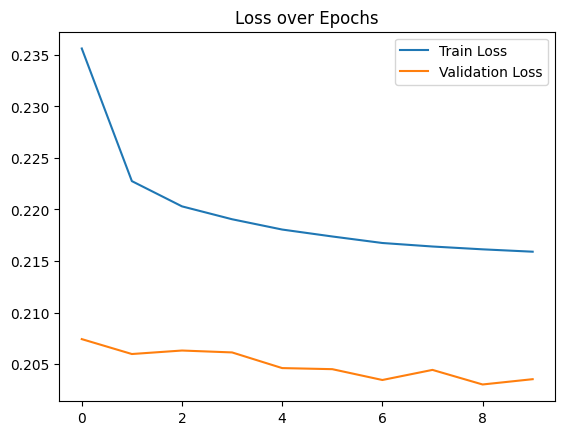

In [37]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

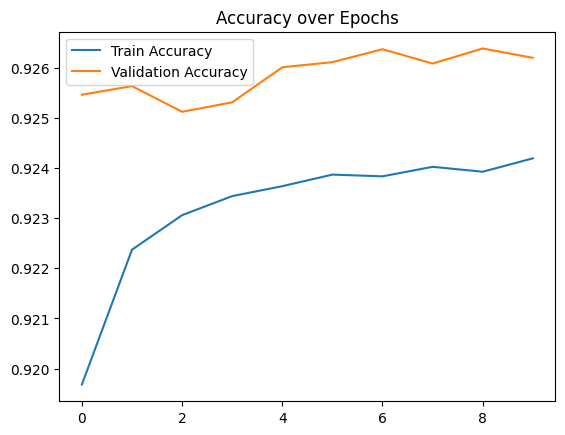

In [38]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [39]:
y_val_preds = np.argmax(nn_model.predict(X_nn_val), axis=1)

10915/10915 ━━━━━━━━━━━━━━━━━━━━ 10s 933us/step


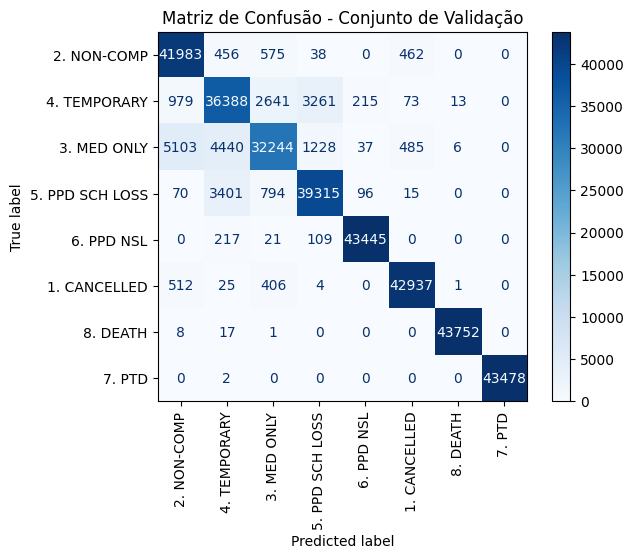

In [40]:
mapa_codificacao = {
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'    
    }

conf_matrix = confusion_matrix(y_nn_val, y_val_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(mapa_codificacao.values()))
disp.plot(cmap='Blues', xticks_rotation='vertical')

plt.title("Matriz de Confusão - Conjunto de Validação")
plt.show()

In [41]:
report = classification_report(y_nn_val, y_val_preds, target_names=list(mapa_codificacao.values()))
print(report)

                 precision    recall  f1-score   support

    2. NON-COMP       0.86      0.96      0.91     43514
   4. TEMPORARY       0.81      0.84      0.82     43570
    3. MED ONLY       0.88      0.74      0.80     43543
5. PPD SCH LOSS       0.89      0.90      0.90     43691
     6. PPD NSL       0.99      0.99      0.99     43792
   1. CANCELLED       0.98      0.98      0.98     43885
       8. DEATH       1.00      1.00      1.00     43778
         7. PTD       1.00      1.00      1.00     43480

       accuracy                           0.93    349253
      macro avg       0.93      0.93      0.93    349253
   weighted avg       0.93      0.93      0.93    349253



In [44]:
mapa_codificacao = {
    0: '2. NON-COMP',
    1: '4. TEMPORARY',
    2: '3. MED ONLY',
    3: '5. PPD SCH LOSS',
    4: '6. PPD NSL',
    5: '1. CANCELLED',
    6: '8. DEATH',
    7: '7. PTD'
}

claim_ids = data_test_FS["Claim Identifier"]

final_test_predictions = nn_model.predict(test_predictions_rf)
final_test_labels = np.argmax(final_test_predictions, axis=1)


final_test_labels_coded = [mapa_codificacao[label] for label in final_test_labels]

results = pd.DataFrame({
    "Claim Identifier": claim_ids,
    "Claim Injury Type": final_test_labels_coded
})

results.to_csv("../predictions/group_40_KFold_RF_NN_predictions.csv", index=False)
print("Predições salvas em '../predictions/group_40_KFold_RF_NN_predictions.csv'.")


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Predições salvas em '../predictions/group_40_KFold_RF_NN_predictions.csv'.


In [45]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_RF_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()

values

Claim Injury Type
2. NON-COMP        320560
4. TEMPORARY        52441
1. CANCELLED         7871
3. MED ONLY          6150
5. PPD SCH LOSS       953
Name: count, dtype: int64